# Damped Rippler algorithm

We take a very simple SI model, providing a simulation on which to run the damped rippler.  Importantly, we make sure that the population size is large, such that the rippler hitting probability is small.

In [124]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from gemlib.distributions import DiscreteTimeStateTransitionModel
from gemlib.util import compute_state
from gemlib.mcmc import CBRKernel

from damped_chain_binomial_rippler import DampedCBRKernel

%matplotlib inline

tfd = tfp.distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
incidence_matrix = np.array([[-1, 1, 0],
                             [0, -1, 1]])
initial_conditions = np.array([[1e5, 100, 0]], np.float32)

def transition_rate_fn(t, state):
    infec_rate =  0.2 * state[:, 1] / tf.reduce_sum(state)
    removal_rate = tf.broadcast_to(tf.constant([0.14]), infec_rate.shape)
    return infec_rate, removal_rate

model = DiscreteTimeStateTransitionModel(transition_rates=transition_rate_fn,
                                         initial_state=initial_conditions,
                                         initial_step=0,
                                         time_delta=1.0,
                                         num_steps=84*2,
                                         stoichiometry=incidence_matrix)

sim = model.sample(seed=2)

observation_model = tfd.Binomial(total_count=sim[..., 1], probs=0.5)
observations = observation_model.sample()

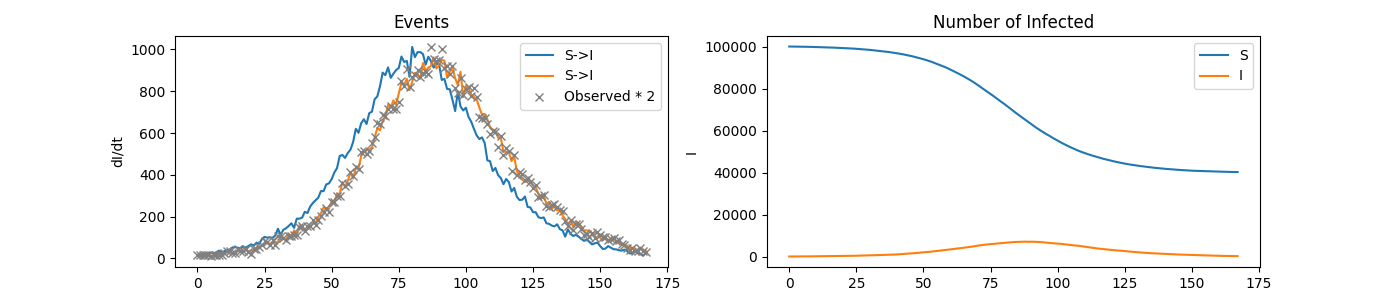

In [298]:
def plot_sim(sim, observations):
    fig, ax = plt.subplots(1, 2, figsize=(14, 3))

    ax[0].plot(tf.reduce_sum(sim, axis=0), label="S->I")
    ax[0].set_ylabel("dI/dt")
    ax[0].set_title("Events")
    
    ax[0].plot(tf.reduce_sum(observations, axis=0)*2, "x", color='grey', label="Observed * 2")
    ax[0].legend()
    
    state = compute_state(initial_conditions, sim, incidence_matrix)
    ax[1].plot(tf.reduce_sum(state[..., 0], axis=0), label="S")
    ax[1].plot(tf.reduce_sum(state[..., 1], axis=0), label="I")
    #ax[1].plot(tf.reduce_sum(state[..., 2], axis=0), label="R")
    ax[1].set_ylabel("I")
    ax[1].set_title("Number of Infected")
    ax[1].legend()
    
plot_sim(sim, observations)


In [299]:
def plot_rippler_samples(samples, original):
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    ax.plot([], color="pink", label="I->R samples")
    ax.plot(tf.transpose(samples[:, 0, :, 0]), color="pink", alpha=0.2)
    ax.plot(original[0, :, 0], color='black', label="True")
    ax.set_title("Events")
    ax.legend()

## Undamped rippler

In [308]:
def target_log_prob_fn(sim):
    return tf.reduce_sum(
        tfd.Binomial(total_count=sim[...,1], probs=0.5).log_prob(observations)
    )

In [309]:
rippler_kernel = CBRKernel(target_log_prob_fn=target_log_prob_fn, model=model)

@tf.function(jit_compile=True)
def rippler_sample():
     return tfp.mcmc.sample_chain(num_results=5000,
                                  kernel=rippler_kernel,
                                  current_state=sim)
    
rippler_samples, rippler_results = rippler_sample()
print("Acceptance:", rippler_results.is_accepted.numpy().mean())

/home/jewellcp/tmp/chain_binomial_rippler/.venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2022-10-11 08:38:08.155298: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_sample_chain/trace_scan/while/smart_for_loop/while/CBRKernel/one_step/while/draw_events/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert


Acceptance: 0.5944


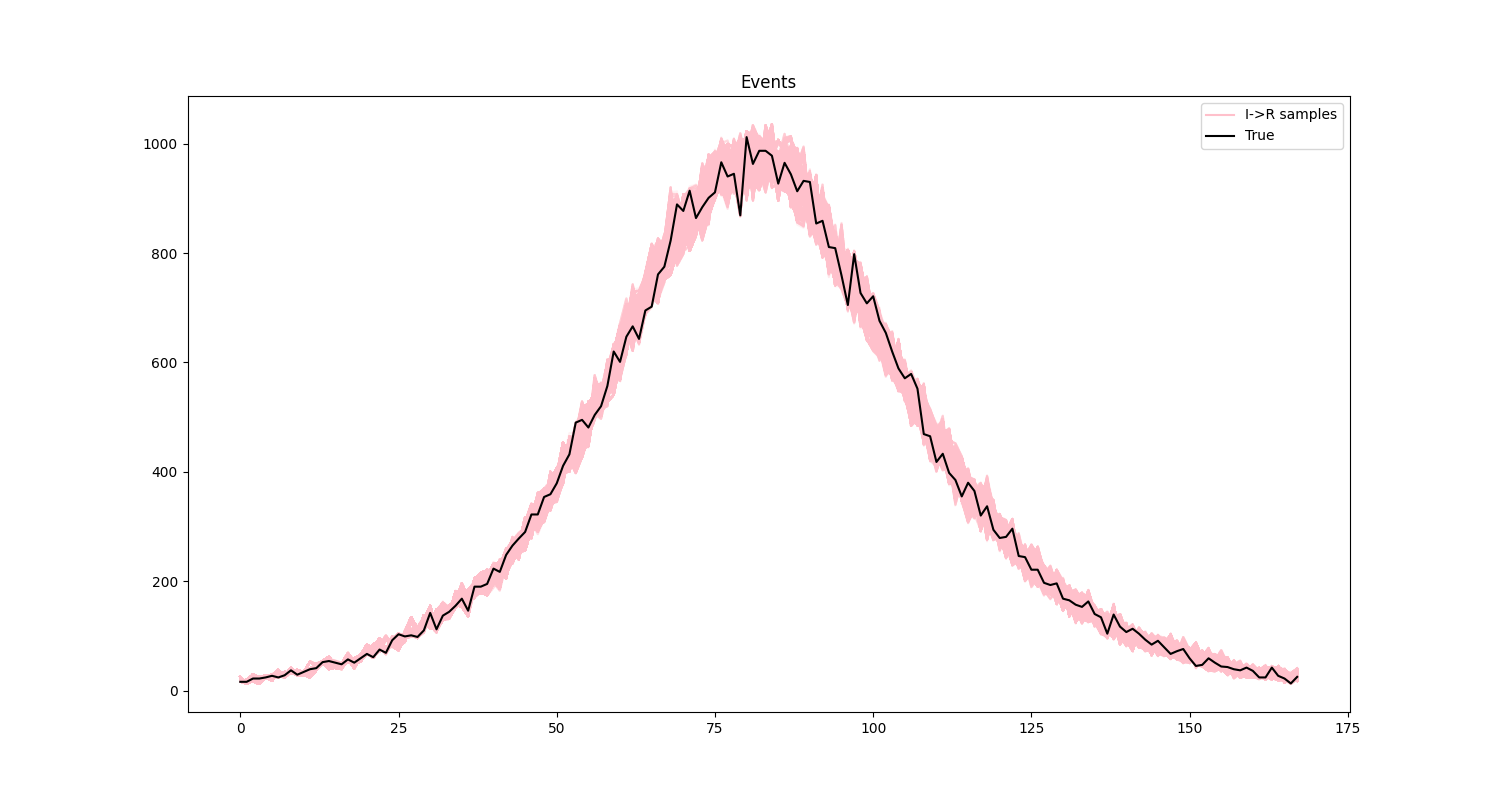

In [310]:
plot_rippler_samples(rippler_samples, sim)
plt.savefig("undamped_rippler_IR.pdf")

# Introducing the damped rippler algorithm


## Damped rippler with $\gamma = 1$

In [319]:
kernel = DampedCBRKernel(target_log_prob_fn=target_log_prob_fn, model=model, ripple_damping_constant=1.0)

In [321]:
@tf.function(jit_compile=True)
def sample():
    return tfp.mcmc.sample_chain(num_results=5000, kernel=kernel, current_state=sim, seed=[195952,1])

new_events, results = sample()

/home/jewellcp/tmp/chain_binomial_rippler/.venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2022-10-11 08:55:15.136376: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_sample_chain/trace_scan/while/smart_for_loop/while/CBRKernel/one_step/while/draw_events/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert


In [322]:
print("Acceptance:", results.is_accepted.numpy().mean())

Acceptance: 0.6058


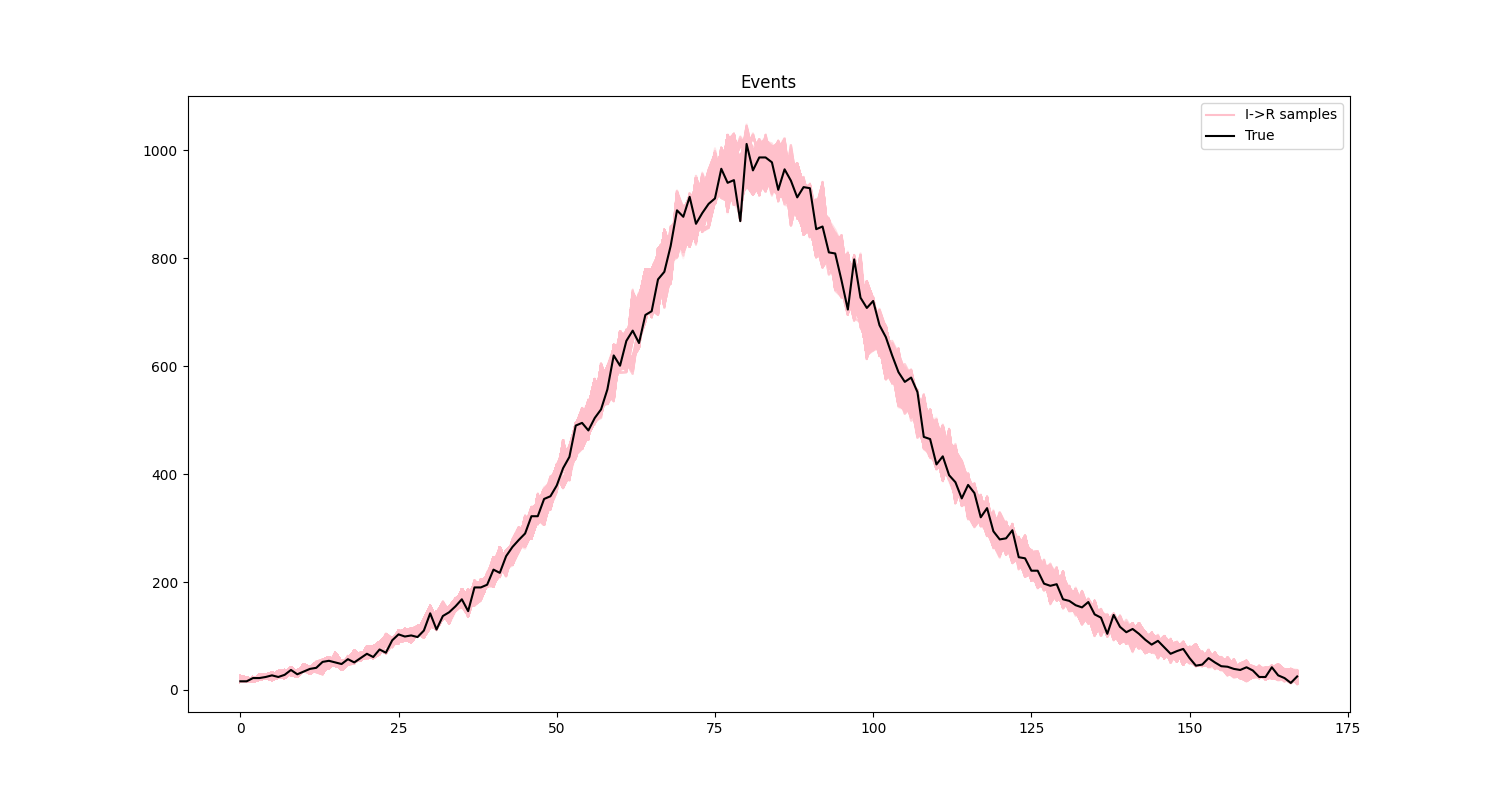

In [323]:
%matplotlib widget
plot_rippler_samples(new_events, sim)
plt.savefig("damped_rippler_IR.pdf")

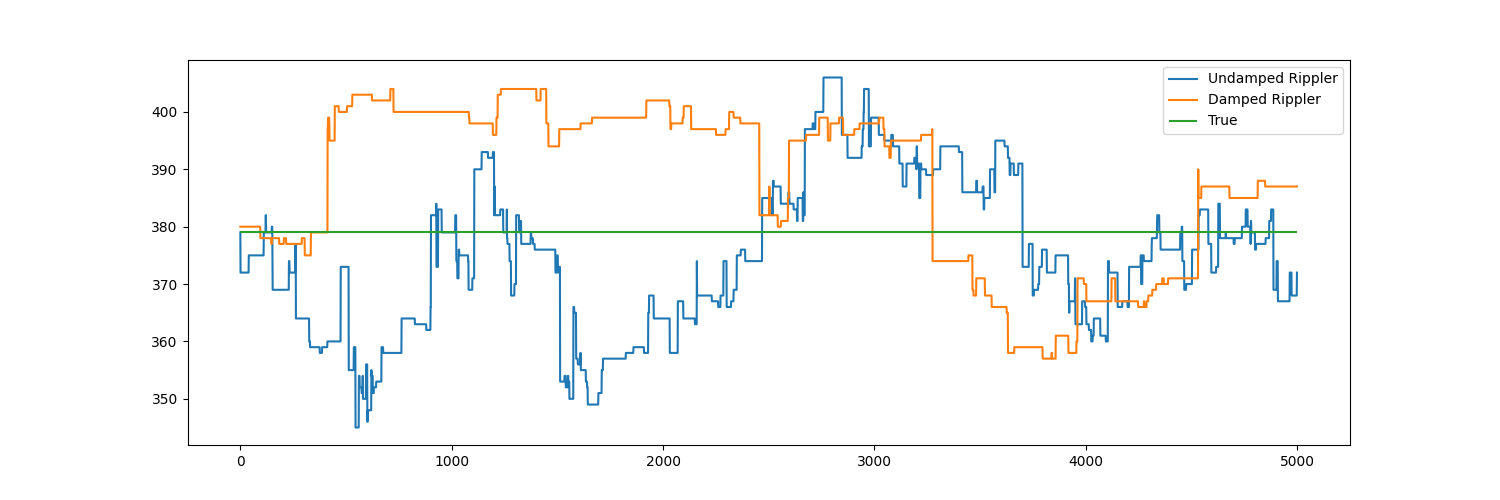

In [315]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(rippler_samples[:, 0, 50, 0], label="Undamped Rippler")
plt.plot(new_events[:, 0, 50, 0], label="Damped Rippler")
plt.hlines(sim[0, 50, 0], 0, new_events.shape[0], color="C2", label="True")
plt.legend()

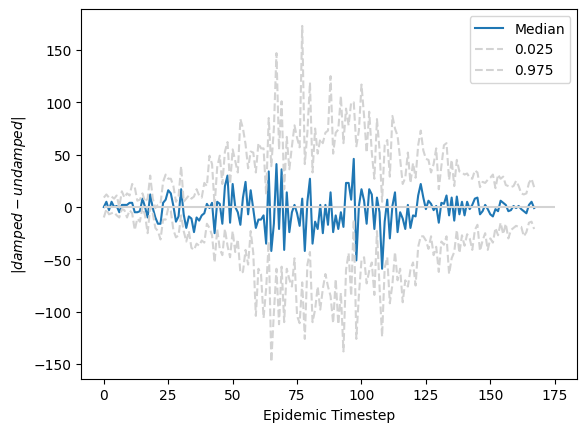

In [316]:
%matplotlib inline
diff = tf.math.reduce_sum(new_events - rippler_samples, axis=(1, 3))
q = tfp.stats.percentile(diff, q=(2.5, 50, 97.5), axis=0)

plt.plot(q[1], label="Median")
plt.plot(q[0], linestyle="--", color="lightgrey", label="0.025")
plt.plot(q[2], linestyle="--", color="lightgrey", label="0.975")
plt.hlines(0, 0, 175, color="lightgrey")
plt.xlabel("Epidemic Timestep")
plt.ylabel("$|damped - undamped|$")
plt.legend()
plt.savefig("absolute_err.pdf")

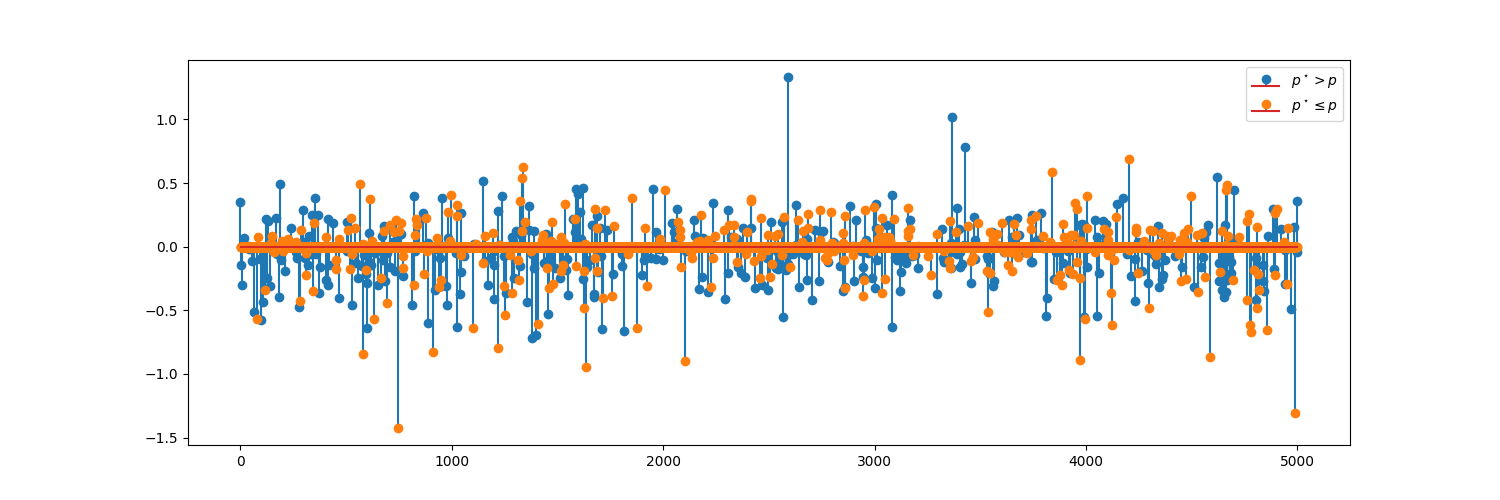

In [317]:
%matplotlib widget

def plot_jacobian(results, timepoint=100):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    is_ps_gt_p = results.is_ps_gt_p[:, timepoint, 0, 0].numpy()
    log_acceptance_correction = results.log_acceptance_correction[:, timepoint, 0, 0].numpy()
    
    ps_gt_p_idx = np.arange(is_ps_gt_p.shape[0])[is_ps_gt_p]
    p_leq_ps_idx = np.arange(is_ps_gt_p.shape[0])[~is_ps_gt_p]
    ax.stem(ps_gt_p_idx, log_acceptance_correction[is_ps_gt_p], label="$p^\star > p$")
    ax.stem(p_leq_ps_idx, log_acceptance_correction[~is_ps_gt_p], markerfmt="C1o", label="$p^\star \leq p$")

    ax.legend()
    
plot_jacobian(results, 30)

In [142]:
def tabulate_jacobian(results, timepoint=100, transition=0, filter_zeros=True):
    
    df = pd.DataFrame({"pstar > p": results.is_ps_gt_p[:, timepoint, transition, 0].numpy(),
                       "log_jacobian": results.log_acceptance_correction[:, timepoint, transition, 0],
                       "log_jacobian_sign": pd.Categorical(
                           np.where(results.log_acceptance_correction[:, timepoint, transition, 0] > 0, "positive", "negative"),
                           categories=["positive", "negative"], ordered=False)})

    if filter_zeros is True:
        df = df[df["log_jacobian"] != 0.0]
    
    crosstab = pd.crosstab(index=df["pstar > p"], columns=df["log_jacobian_sign"])
    crosstab["Pr(positive)"] = crosstab["positive"]/crosstab.sum(axis="columns")
    return crosstab.sort_index(ascending=False)

tabulate_jacobian(results, timepoint=100, transition=0, filter_zeros=True).round(decimals=2)

KeyError: 'positive'

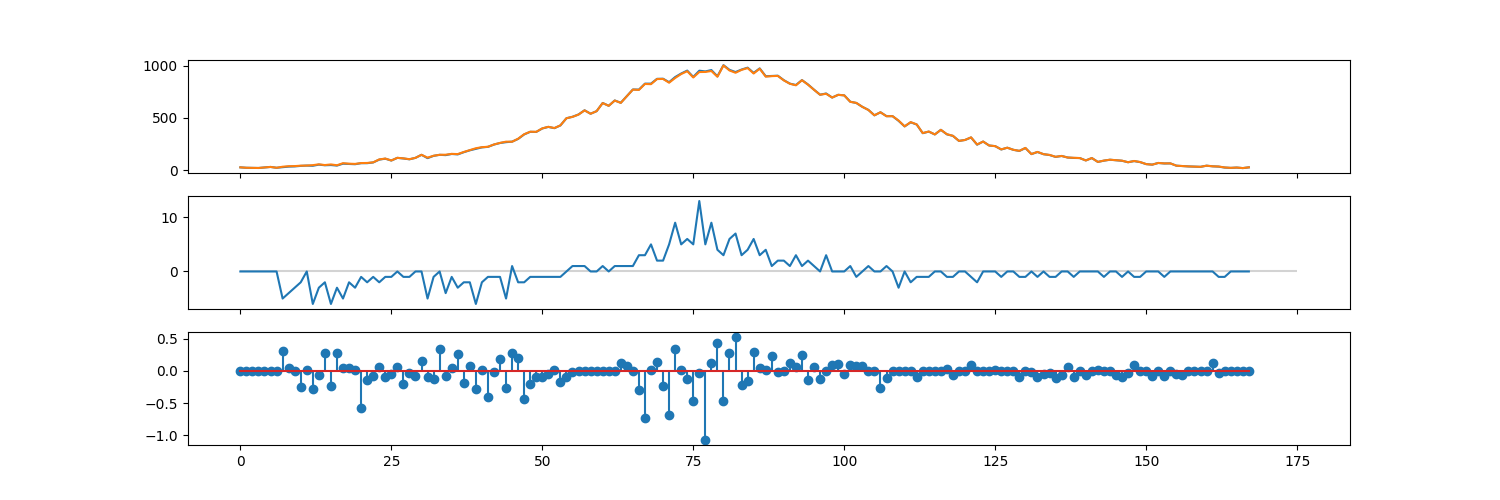

In [318]:

def plot_single_timepoint(iteration):
    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
    ax[0].plot(new_events[iteration-1, 0, :, 0], label="Current")
    ax[0].plot(results.proposed_state[iteration, 0, :, 0], label="Proposed")
    ax[1].plot(new_events[iteration-1, 0, :, 0]-results.proposed_state[iteration, 0, :, 0])
    ax[1].hlines(0, 0, 175, color="lightgrey", zorder=-1)
    ax[2].stem(results.log_acceptance_correction[iteration, :, 0, 0])
    
plot_single_timepoint(3009)

# Intuition

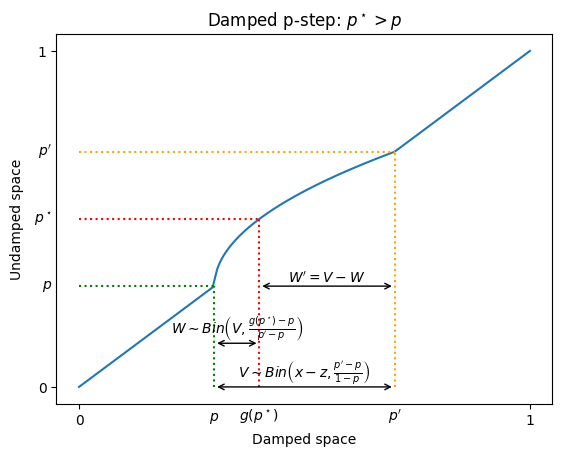

In [285]:
from damped_chain_binomial_rippler import DampingFunction

def fig_ps_gt_p():
    df = DampingFunction(0.3, 0.7, 2.0)
    
    x = np.linspace(0, 1, 200)
    plt.plot(x, df.inverse(x), label="g(x)")
    plt.vlines(0.3, 0, df(0.3), color="green", linestyle="dotted")
    plt.hlines(df(0.3), 0, 0.3, color="green", linestyle="dotted")

    plt.vlines(df(0.5), 0, 0.5, color="red", linestyle="dotted")
    plt.hlines(0.5, 0, df(0.5), color="red", linestyle="dotted")

    plt.vlines(0.7, 0, df(0.7), color="orange", linestyle="dotted")
    plt.hlines(df(0.7), 0, 0.7, color="orange", linestyle="dotted")

    plt.text(x=0.3, y=-0.1, s=r"$p$", horizontalalignment="center")
    plt.text(x=df(0.5), y=-0.1, s=r"$g(p^\star)$", horizontalalignment="center")
    plt.text(x=0.7, y=-0.1, s=r"$p^\prime$", horizontalalignment="center")

    plt.text(x=-0.06, y=0.3, s=r"$p$", horizontalalignment="right", verticalalignment="center")
    plt.text(x=-0.06, y=0.5, s=r"$p^\star$", horizontalalignment="right", verticalalignment="center")
    plt.text(x=-0.06, y=0.7, s=r"$p^\prime$", horizontalalignment="right", verticalalignment="center")
    
    plt.annotate("", xy=(0.3, 0.0), xytext=(0.7, 0.0), arrowprops=dict(arrowstyle="<->"))
    plt.text(x=0.5, y=0.0, s=r"$V \sim Bin\left(x-z, \frac{p^\prime - p}{1-p}\right)$",
             verticalalignment="bottom", horizontalalignment="center")

    plt.annotate("", xy=(0.3, 0.13), xytext=(df(0.5), 0.13), arrowprops=dict(arrowstyle="<->"))
    plt.text(x=(0.3 + df(0.5))/2, y=0.13, 
             s=r"$W \sim Bin\left(V, \frac{g(p^\star) - p}{p^\prime-p}\right)$",
            verticalalignment="bottom",
            horizontalalignment="center")
    
    plt.annotate("", xy=(df(0.5), 0.3), xytext=(0.7, 0.3), arrowprops=dict(arrowstyle="<->"))
    plt.text(x=(df(0.5)+0.7)/2, y=0.3, s="$W^\prime = V-W$", horizontalalignment="center", verticalalignment="bottom")

    plt.xticks([0, 1])
    plt.yticks([0, 1])

    plt.xlabel("Damped space")
    plt.ylabel("Undamped space", labelpad=10)
    plt.title(r"Damped p-step: $p^\star > p$")
    plt.savefig("damped_p_rippler_ps_gt_p.png")
    plt.savefig("damped_p_rippler_ps_gt_p.pdf")
    
fig_ps_gt_p()

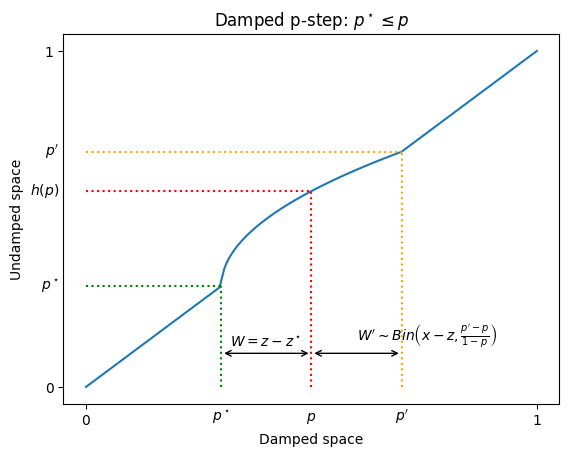

In [288]:
def fig_ps_leq_p():
    damping_fn = DampingFunction(0.3, 0.7, 2.0)
    df = damping_fn.inverse

    x = np.linspace(0, 1, 200)
    plt.plot(x, df(x), label="g(x)")
    plt.vlines(0.3, 0, df(0.3), color="green", linestyle="dotted")
    plt.hlines(df(0.3), 0, 0.3, color="green", linestyle="dotted")

    plt.vlines(0.5, 0, df(0.5), color="red", linestyle="dotted")
    plt.hlines(df(0.5), 0, 0.5, color="red", linestyle="dotted")

    plt.vlines(0.7, 0, df(0.7), color="orange", linestyle="dotted")
    plt.hlines(df(0.7), 0, 0.7, color="orange", linestyle="dotted")

    plt.text(x=0.3, y=-0.1, s=r"$p^\star$", horizontalalignment="center")
    plt.text(x=0.5, y=-0.1, s=r"$p$", horizontalalignment="center")
    plt.text(x=0.7, y=-0.1, s=r"$p^\prime$", horizontalalignment="center")

    plt.text(x=-0.06, y=0.3, s=r"$p^\star$", horizontalalignment="right", verticalalignment="center")
    plt.text(x=-0.06, y=df(0.5), s=r"$h(p)$", horizontalalignment="right", verticalalignment="center")
    plt.text(x=-0.06, y=0.7, s=r"$p^\prime$", horizontalalignment="right", verticalalignment="center")
    
    plt.annotate("", xy=(0.3, 0.1), xytext=(0.5, 0.1), arrowprops=dict(arrowstyle="<->"))
    plt.text(x=0.4, y=0.11, 
             s=r"$W = z - z^\star$",
            verticalalignment="bottom",
            horizontalalignment="center")
    plt.annotate("", xy=(0.5, 0.1), xytext=(0.7, 0.1), arrowprops=dict(arrowstyle="<->"))
    plt.text(x=0.6, y=0.11, s=r"$W^\prime \sim Bin\left(x-z, \frac{p^\prime - p}{1-p}\right)$",
            verticalalignment="bottom",
            horizontalalignment="left")

    plt.xticks([0, 1])
    plt.yticks([0, 1])

    plt.xlabel("Damped space")
    plt.ylabel("Undamped space", labelpad=15)

    plt.title("Damped p-step: $p^\star \leq p$")
    plt.savefig("damped_p_rippler_ps_leq_p.png")
    plt.savefig("damped_p_rippler_ps_leq_p.pdf")
    
fig_ps_leq_p()

# Transformed Binomial

Suppose we have $z \sim \mbox{Binomial}(1000, p=0.2)$, and we apply the above transform.

In [268]:
p = 0.2
ps = 0.5
x = 1000
z = tfd.Binomial(total_count=x, probs=p).sample(4000)

<AxesSubplot: ylabel='Density'>

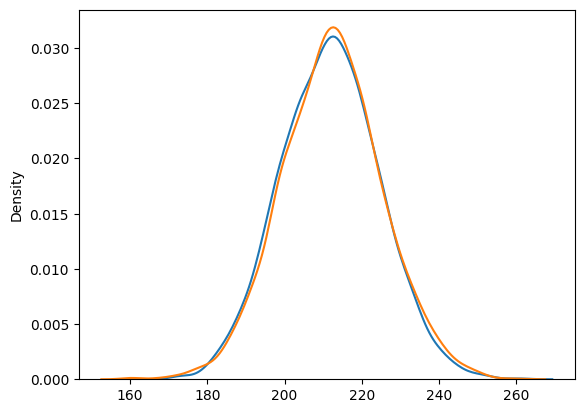

In [275]:
%matplotlib inline

from damped_chain_binomial_rippler import DampingFunction
from damped_chain_binomial_rippler import _reduce_first_n

upper_bound = 2*ps - p
damp = DampingFunction(p=p, upper_bound=upper_bound, gamma=1.5)

v = tfd.Binomial(total_count=x-z, probs=(upper_bound - p) / (1.0 - p)).sample()
w = tfd.Binomial(total_count=v, probs=(damp(ps) - p) / (upper_bound - p)).sample()
z_star = z + w


u = tfd.Uniform(low=p, high=1.0).sample(sample_shape=(1000, 4000))
transformed_u = damp.inverse(u)

wu = _reduce_first_n(values=tf.cast(transformed_u < ps, tf.float32), n=x-z)

sns.kdeplot(w)
sns.kdeplot(wu)

Now let's do the same transformation, just by materialising some Uniform random variables

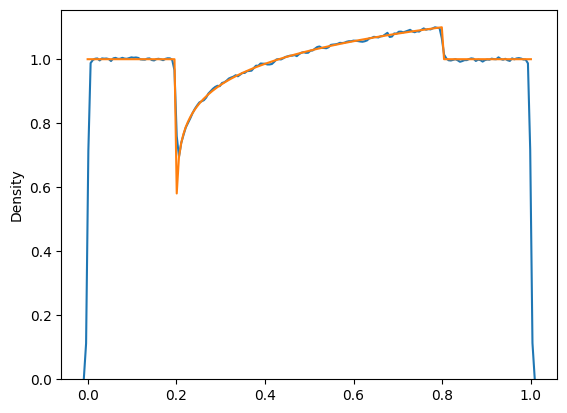

In [277]:
u = tfd.Uniform().sample(sample_shape=(10000000))

# Transform the u's
upper_bound = 2*ps - p
damp = DampingFunction(p=p, upper_bound=upper_bound, gamma=1.1)

u_star = damp.inverse(u)

# Now create a function that returns the PMF given a sequence of u values
def damped_pmf(u_values):
    return tfd.Uniform().log_prob(damp(u_values)) - damp.log_inverse_jacobian(damp(u_values))

sns.kdeplot(u_star, bw_adjust=0.25)
u_prime = np.linspace(0, 1, 200)
plt.plot(u_prime, np.exp(damped_pmf(u_prime)))